In [13]:
import os
import numpy as np
import pandas as pd
from time import time

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 26

data_dir = "/home/stavros/DATA/AirbnbReviews"
#data_dir = "D:/"

In [14]:
area = "nyc"
area_dir = os.path.join(data_dir, area)

data = pd.read_csv(os.path.join(area_dir, "reviews.csv.gz"))
print(data.shape)

clean_data = data[pd.notnull(data.comments)]
print(clean_data.shape)

(1166689, 6)
(1166096, 6)


In [15]:
import langdetect
from utils import dependencies
from utils import preprocessing


normalizer = preprocessing.CorpusNormalizer(
                 html_stripping=False, contraction_expansion=True,
                 accented_char_removal=True, text_lower_case=True,
                 text_lemmatization=False, special_char_removal=False,
                 stopword_removal=False, remove_digits=False)

n_samples = 2000
n_message = 500

ids = np.arange(len(clean_data))
np.random.shuffle(ids)

sampled_columns = list(clean_data.columns) + ["processed_comments", "word_features"]
sampled_data = pd.DataFrame(index=range(n_samples), columns=sampled_columns)
i, ic = 0, 0
while ic < n_samples:
    data_row = clean_data.iloc[ids[i]]
    review = data_row["comments"]
    i += 1
    if (not isinstance(review, str)) or len(review) < 5:
        # Skip invalid reviews
        continue
    if "canceled" in review:
        # If it is an automated cancellation review then skip
        continue
    try:
        review_lang = langdetect.detect(review)
    except:
        continue
    if review_lang != "en":
        continue
        
    processed_review = normalizer([review])[0]
    sampled_data.iloc[ic] = data_row
    sampled_data.iloc[ic]["processed_comments"] = processed_review
    sampled_data.iloc[ic]["word_features"] = dependencies.find_features(processed_review)
    ic += 1
        
    if ic % n_message == 0:
        print("{} / {} found.".format(ic + 1, n_samples))

501 / 2000 found.
1001 / 2000 found.
1501 / 2000 found.
2001 / 2000 found.


In [19]:
sampled_data.to_csv(os.path.join(area_dir, "reviews_with_word_features_{}samples.csv".format(n_samples)), 
                    index=False)

print(clean_data.columns)
print(sampled_data.shape)
print(sampled_data.columns)

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')
(2000, 8)
Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments',
       'processed_comments', 'word_features'],
      dtype='object')


In [20]:
import collections

total_counter = collections.Counter()
for counter in sampled_data.word_features:
    total_counter += counter
print(len(total_counter))

1285


In [21]:
total_counter.most_common(30)

[('place', 646),
 ('location', 526),
 ('host', 438),
 ('apartment', 362),
 ('stay', 293),
 ('room', 163),
 ('neighborhood', 147),
 ('you', 125),
 ('space', 117),
 ('bed', 106),
 ('hosts', 104),
 ('experience', 103),
 ('time', 94),
 ('it', 70),
 ('area', 69),
 ('communication', 63),
 ('value', 60),
 ('restaurants', 55),
 ('house', 50),
 ('access', 40),
 ('home', 39),
 ('neighbourhood', 38),
 ('problem', 38),
 ('spot', 37),
 ('bathroom', 36),
 ('people', 36),
 ('beds', 33),
 ('issue', 32),
 ('food', 29),
 ('check', 29)]

This leads to memory error

In [12]:
import gensim
google_vec_file = os.path.join(data_dir, "GoogleNews-vectors-negative300.bin.gz")
word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True, limit=200000)

import pickle
pickle.dump(word2vec, open(os.path.join(data_dir, "word2vec_google.pkl"), 'wb'))

In [55]:
word_vectors = []
word2vecind = {}
for word, _ in total_counter.most_common(100):
    if word in word2vec.vocab:
        word2vecind[word] = len(word_vectors)
        word_vectors.append(word2vec[word])
    else:
        print("{} not in Word2Vec vocab.".format(word))

word_vectors = np.array(word_vectors)
word_vectors.shape

neighbourhood not in Word2Vec vocab.
appartment not in Word2Vec vocab.
street noise not in Word2Vec vocab.
airbnb not in Word2Vec vocab.
check in not in Word2Vec vocab.


(95, 300)

In [57]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=5)

wordvecs_reduced = pca.fit_transform(word_vectors)
print(wordvecs_reduced.shape)

(95, 5)


[0.5031363  0.35331637 0.27677715 0.2451345  0.23419106]


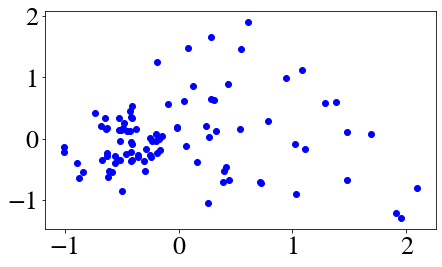

In [59]:
print(pca.explained_variance_)
plt.figure(figsize=(7, 4))
plt.scatter(wordvecs_reduced[:, 0], wordvecs_reduced[:, 1], color="blue")
plt.show()

In [27]:
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=5)
words_clustered = kmeans.fit_transform(word_vectors)
words_clustered.shape

(95, 5)

In [42]:
vecind2word = {v: k for k, v in word2vecind.items()}
clusters = [{vecind2word[i] for i in np.where(kmeans.labels_ == n)[0]} for n in range(kmeans.n_clusters)]
for cluster in clusters:
    print(cluster)

{'convenience', 'comfort', 'communication', 'amenities', 'views', 'access', 'accommodations', 'wifi', 'view', 'value', 'experience'}
{'home', 'host', 'location', 'gem', 'neighborhood', 'places', 'bars', 'tips', 'spots', 'hosts', 'place', 'area', 'spot'}
{'apartment', 'loft', 'brownstone', 'kitchen', 'bathroom', 'house', 'bedroom', 'studio'}
{'which', 'work', 'amount', 'lot', 'pleasure', 'days', 'communicator', 'it', 'hostess', 'touch', 'trouble', 'recommendations', 'vibe', 'way', 'clean', 'weather', 'time', 'you', 'issue', 'breeze', 'master', 'issues', 'noise', 'me', 'touches', 'suggestions', 'guy', 'problem', 'person', 'cat', 'trip', 'things', 'family', 'us', 'price', 'problems', 'fun', 'check', 'walk', 'cats', 'this', 'people', 'one', 'stay', 'part'}
{'size', 'rooms', 'food', 'towels', 'welcome', 'room', 'parking', 'cleanliness', 'shops', 'beds', 'space', 'restaurants', 'hospitality', 'decor', 'bed', 'shower', 'street', 'building'}


In [50]:
categories = ["clean", "host", "location", "value"]
for word in categories:
    assert word in word2vec.vocab

In [54]:
for word, _ in total_counter.most_common(50):
    if word in word2vec.vocab:
        distances = word2vec.distances(word, categories)
        match_cat = categories[distances.argmin()]
        print("{}: {}".format(word, distances))
    else:
        print("{} not in vocab.".format(word))

place: [0.8325644  0.74842465 0.6726596  0.9157255 ]
location: [0.97479033 0.82070947 0.         0.85033464]
host: [0.9393692  0.         0.82070947 1.0019288 ]
apartment: [0.89290535 1.0502918  0.78139174 0.9863219 ]
stay: [0.7624167  0.8861873  0.8261593  0.97917396]
room: [0.8714406  0.93346524 0.86026    0.987429  ]
neighborhood: [0.89349914 0.96486574 0.6623925  0.9690883 ]
you: [0.88288915 0.9634835  0.9329579  0.87056786]
space: [0.86487275 0.90905786 0.74970853 0.84904605]
bed: [0.85696244 0.9281334  0.9166598  0.98183423]
hosts: [0.9723166 0.2905022 0.8412068 1.0202814]
experience: [0.9860507  0.95252246 0.84158754 0.7925668 ]
time: [0.89732057 0.9517934  0.8008967  0.85190344]
it: [0.76111764 0.94642377 0.789051   0.7760515 ]
area: [0.8992999  0.89961255 0.5375757  0.95438087]
communication: [0.97707725 0.99670446 0.857627   0.8742633 ]
value: [ 9.7388792e-01  1.0019288e+00  8.5033464e-01 -1.1920929e-07]
restaurants: [0.8824699  0.92270434 0.7361413  0.9251872 ]
house: [0.860